# Problem Set 5
**Owen Erker**

---

## Instructions

The goal of this problem set is to get some experience with transformers.
There's a neat minimal implementation of GPT by Andrej Karpathy here https://github.com/karpathy/minGPT.

1. Explore this repo. Find an implementation of training the GPT for adding numbers in https://github.com/karpathy/minGPT/blob/master/projects/adder/adder.py
2. Notice this
```
class AdditionDataset(Dataset):
    """
    Creates n-digit addition problems. For example, if n=2, then an example
    addition problem would be to add 85 + 50 = 135. This problem would be
    represented as the following string for the GPT:

    "8550531"

    This is because:
    - we are discarding the + and =, which are not necessary. We just encode the digits
      of the input numbers concatenated together.
    - the result 135 is encoded backwards to make the addition easier to learn for the
      GPT model, because of how the addition algorithm works.

    As one more example, the problem 6 + 39 = 45 would be encoded as:

    "0639054"

    where you will notice that we are padding with zeros to make sure that we always
    produce strings of the exact same size: n + n + (n + 1). When n=2, this is 7.
    At test time, we will feed in an addition problem by giving the first 2n digits,
    and hoping that the GPT model completes the sequence with the next (n+1) digits
    correctly.
    """
```
3. We are going to find out the effect of the reversed number representation.

  - Set ndigit = 3 to learn the addition of 3 digit numbers.
  - Set the max number of training iterations to 20_000.
  - Run two experiments where you learn the addition with and without the trick reversing the target.
  - In each experiment, record the training and test accuracies (you need to find out how - there are multiple ways you can modify the code to achieve this)
  - Make a plot of training and test accuracies vs. training iteration
  - Does the reversal have any effect? Explain why.


If you chose to run it in colab, you can make use of the following to clone the repo:
```
!git clone https://github.com/karpathy/minGPT.git

```
Then you can import the necessary pieces with, eg.,

```
import sys
sys.path.insert(0, '/content/minGPT')
from mingpt.model import GPT
```

---

## Submission

### Imports

In [1]:
import sys
import os
import shutil
import time

import matplotlib.pyplot as plt
import numpy as np

from IPython.display import display, clear_output
import ipywidgets as widgets

import torch
from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader

#### Check Torch Version and CUDA Status

In [2]:
print(f'Torch Version: {torch.__version__}')
print(f'CUDA Enabled: {torch.cuda.is_available()}')
print(f'CUDA Version: {torch.version.cuda}')
print(f'CUDA Device Name: {torch.cuda.get_device_name()}')

Torch Version: 2.1.0+cu121
CUDA Enabled: True
CUDA Version: 12.1
CUDA Device Name: NVIDIA GeForce RTX 4060 Ti


#### Torch Configurations

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

###  Installation : `minGPT` and `adder_v2.py`

In [4]:
#! git clone https://github.com/karpathy/minGPT.git

sys.path.insert(0, os.path.join(os.getcwd()+'/minGPT'))

from mingpt.model import GPT
from mingpt.trainer import Trainer
from mingpt.utils import set_seed, setup_logging, CfgNode as CN

from projects.adder.adder import get_config, AdditionDataset 

---

### Model Training and Creation

#### Default GPT/Adder Methods

In [5]:
loss_output = widgets.Output()
acc_output = widgets.Output()
eval_output = widgets.Output()

In [6]:
config = get_config()
config.data.ndigit = 3
config.trainer.max_iters = 20_000

train_dataset = AdditionDataset(config.data, split='train')
test_dataset  = AdditionDataset(config.data, split='test')

config.model.vocab_size = train_dataset.get_vocab_size()
config.model.block_size = train_dataset.get_block_size()

model = GPT(config.model)
trainer = Trainer(config.trainer, model, train_dataset)

trainer.device = device
model.to(trainer.device)

number of parameters: 0.09M
running on device cuda


GPT(
  (transformer): ModuleDict(
    (wte): Embedding(10, 48)
    (wpe): Embedding(9, 48)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-2): 3 x Block(
        (ln_1): LayerNorm((48,), eps=1e-05, elementwise_affine=True)
        (attn): CausalSelfAttention(
          (c_attn): Linear(in_features=48, out_features=144, bias=True)
          (c_proj): Linear(in_features=48, out_features=48, bias=True)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((48,), eps=1e-05, elementwise_affine=True)
        (mlp): ModuleDict(
          (c_fc): Linear(in_features=48, out_features=192, bias=True)
          (c_proj): Linear(in_features=192, out_features=48, bias=True)
          (act): NewGELU()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((48,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=48, out_f

In [7]:
def eval_split(trainer, split, max_batches=None):
    with eval_output:
        clear_output(wait=True)
        
        dataset = {'train': train_dataset, 'test': test_dataset}[split]
        ndigit = config.data.ndigit
        results = []
        mistakes_printed_already = 0
        factors = torch.tensor([[10**i for i in range(ndigit+1)][::-1]]).to(trainer.device)
        loader = DataLoader(dataset, batch_size=100, num_workers=0, drop_last=False)

        for b, (x, y) in enumerate(loader):
            x = x.to(trainer.device)
            d1d2 = x[:, :ndigit*2]
            d1d2d3 = model.generate(d1d2, ndigit+1, do_sample=False)
            d3 = d1d2d3[:, -(ndigit+1):].flip(1)

            d1i = (d1d2[:, :ndigit] * factors[:, 1:]).sum(1)
            d2i = (d1d2[:, ndigit:ndigit*2] * factors[:, 1:]).sum(1)
            d3i_pred = (d3 * factors).sum(1)
            d3i_gt = d1i + d2i

            correct = (d3i_pred == d3i_gt).cpu()
            for i in range(x.size(0)):
                results.append(int(correct[i]))
                if not correct[i] and mistakes_printed_already < 5:
                    mistakes_printed_already += 1
                    print(f"GPT Claims: {d1i[i]} + {d2i[i]} = {d3i_pred[i]}\nActual: {d3i_gt[i]}")
            if max_batches is not None and b + 1 >= max_batches:
                break

        rt = torch.tensor(results, dtype=torch.float)
        print(f"-----\nFinal Score [{split}]: {int(rt.sum())}/{len(results)} = {100*rt.mean():.2f}% Correct")
        return rt.sum()

In [8]:
train_acc_log = []
test_acc_log = []
iter_log = []
top_score = 0
score = 0

def batch_end_callback(trainer):
    global top_score


#----------vvv-SYSTEM OUTPUTS-vvv----------
    if trainer.iter_num % 10 == 0:
        with loss_output:
            clear_output(wait=True)
            print(f"Time: {trainer.iter_dt * 1000:.2f}ms\nIteration: {trainer.iter_num} - Train Loss: {trainer.loss.item():.5f}\n-----")

    if trainer.iter_num % 500 == 0:
        model.eval()
        with torch.no_grad():
            train_score = eval_split(trainer, 'train', max_batches=5)
            test_score = eval_split(trainer, 'test')
        score = train_score + test_score
#----------^^^-SYSTEM OUTPUTS-^^^----------

#------------vvv-SYSTEM LOG-vvv------------
        train_pct = float(train_score) / 500 * 100
        test_pct = float(test_score) / 500 * 100

        iter_log.append(trainer.iter_num)
        train_acc_log.append(train_pct)
        test_acc_log.append(test_pct)
#------------^^^-SYSTEM LOG-^^^------------

        if score > top_score:
            top_score = score
            with acc_output:
                clear_output(wait=True)
                print(f"Saving Model with New Top Score: {score}")
            ckpt_path = os.path.join(config.system.work_dir, "model.pt")
            os.makedirs(os.path.dirname(ckpt_path), exist_ok=True)
            torch.save(model.state_dict(), ckpt_path)
        model.train()

In [9]:
display(loss_output)
display(acc_output)
display(eval_output)

trainer.set_callback('on_batch_end', batch_end_callback)
trainer.run()

Output()

Output()

Output()

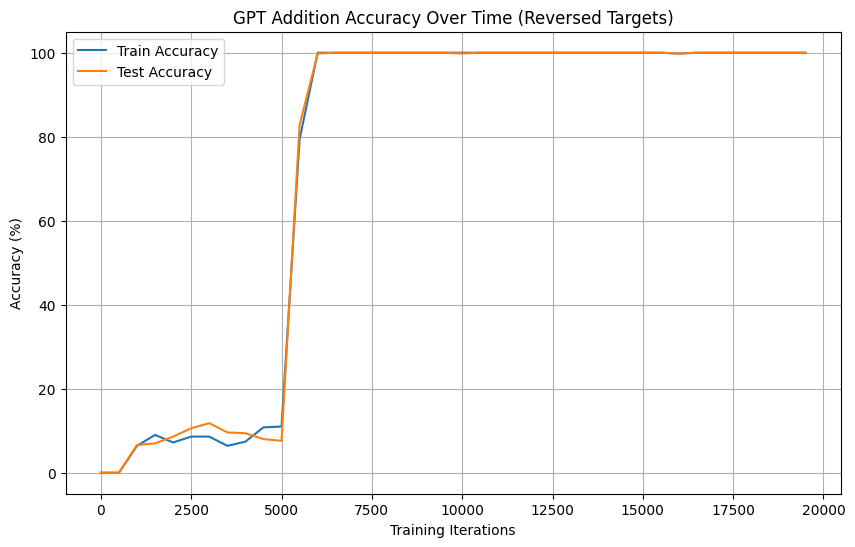

In [10]:
plt.figure(figsize=(10, 6))
plt.plot(iter_log, train_acc_log, label='Train Accuracy')
plt.plot(iter_log, test_acc_log, label='Test Accuracy')
plt.xlabel("Training Iterations")
plt.ylabel("Accuracy (%)")
plt.title("GPT Addition Accuracy Over Time (Reversed Targets)")
plt.legend()
plt.grid(True)
plt.show()

#### Modified GPT/Adder Methods for Experiment

In [11]:
ckpt_path = './out/adder/model.pt'
if os.path.exists(ckpt_path):
    os.remove(ckpt_path)
    print("Old model deleted.")

Old model deleted.


In [12]:
config = get_config()
config.data.ndigit = 3
config.trainer.max_iters = 20_000
config.data.reverse_target = False

train_dataset = AdditionDataset(config.data, split='train')
test_dataset  = AdditionDataset(config.data, split='test')

config.model.vocab_size = train_dataset.get_vocab_size()
config.model.block_size = train_dataset.get_block_size()

model = GPT(config.model)
trainer = Trainer(config.trainer, model, train_dataset)

trainer.device = device
model.to(trainer.device)

number of parameters: 0.09M
running on device cuda


GPT(
  (transformer): ModuleDict(
    (wte): Embedding(10, 48)
    (wpe): Embedding(9, 48)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-2): 3 x Block(
        (ln_1): LayerNorm((48,), eps=1e-05, elementwise_affine=True)
        (attn): CausalSelfAttention(
          (c_attn): Linear(in_features=48, out_features=144, bias=True)
          (c_proj): Linear(in_features=48, out_features=48, bias=True)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((48,), eps=1e-05, elementwise_affine=True)
        (mlp): ModuleDict(
          (c_fc): Linear(in_features=48, out_features=192, bias=True)
          (c_proj): Linear(in_features=192, out_features=48, bias=True)
          (act): NewGELU()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((48,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=48, out_f

In [13]:
train_acc_log = []
test_acc_log = []
iter_log = []
top_score = 0
score = 0

In [14]:
display(loss_output)
display(acc_output)
display(eval_output)

trainer.set_callback('on_batch_end', batch_end_callback)
trainer.run()

Output()

Output()

Output()

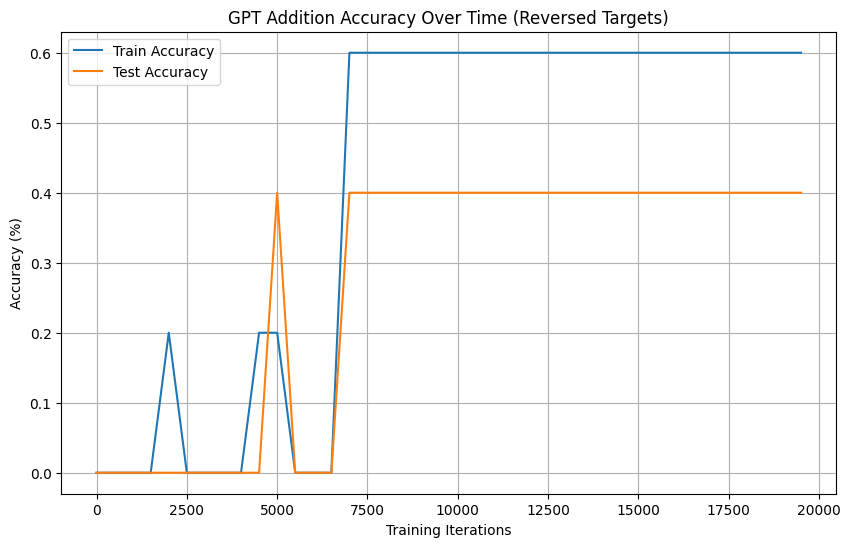

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(iter_log, train_acc_log, label='Train Accuracy')
plt.plot(iter_log, test_acc_log, label='Test Accuracy')
plt.xlabel("Training Iterations")
plt.ylabel("Accuracy (%)")
plt.title("GPT Addition Accuracy Over Time (Normal Targets)")
plt.legend()
plt.grid(True)
plt.show()

#### Comparison

Our experiments demonstrate a clear advantage to using the reversed target format when training a GPT model to perform 3-digit addition. When the target output was reversed (learning "135" as "531"), both training and test accuracies reached 100%, indicating that the model was able to learn and generalize the addition operation perfectly. In contrast, the standard format (non-reversed) led to significantly lower accuracies, with the training accuracy plateauing at 60% and the test accuracy dropping to 40%.

This stark difference highlights how sequence structure impacts model learning. Reversing the output simplifies the dependency structure of digit-by-digit addition, making it easier for the autoregressive GPT to learn—especially since it generates outputs from left to right. Without reversal, the model must learn to carry digits forward before it's seen them, which is much harder to capture with causal attention.